___Predicting macrophage inflammatory activation from upstream signaling events___

Data from my collaborators in the Signaling Systems Section of the Laboratory of Immune System Biology, NIAID, supports a connection between the signaling protein IRAK1 and the NLRP3 inflammasome, which is a key source of pro-inflammatory cytokines in many inflammatory diseases. However, the nature of that connection is not yet clear.

Therefore, this project aims to use machine learning methods to determine whether the pattern of IRAK1 in cells that have been stimulated with inflammasome-activating chemicals can predict which cells will go on to have active NLRP3 inflammasomes (as indicated by the presence of specks of ASC, a protein involved in the NLRP3 inflammasome). The data in this project is live imaging data collected on our lab's high content imager, which automatically detects clusters of fluorescently-tagged IRAK1 and ASC in cells.

My approach will be to use classification algorithms to see if the time-series data of IRAK1 clusters can predict whether a cell will, at a later time point, show an ASC speck.

In [23]:
!pip install tsfresh
!pip install imblearn

In [2]:
import pandas as pd
import numpy as np

# Read in data generated by high-content imaging
irak1cluster_inten_path = "Data/Plate_2019-05-07_ICG-D11-live_KLA-P3C_nig_all-wells_Feature_CircSpotTotalIntenCh3.txt"  # IRAK1 clusters
ascspeck_count_path = "Data/Plate_2019-05-07_ICG-D11-live_KLA-P3C_nig_all-wells_Feature_CircSpotCountCh2.txt"  # ASC specks

irak1cluster_inten_data = pd.read_csv(irak1cluster_inten_path, sep = '\t', header = 0, index_col = [0,1,2])
ascspeck_count_data = pd.read_csv(ascspeck_count_path, sep = '\t', header = 0, index_col = [0,1,2])

# The original data tables have multiple index columns
# Concatenate those into a single index formatted (well, field #, cell #)
irak1cluster_inten_data.index = irak1cluster_inten_data.index.map(str)
ascspeck_count_data.index = ascspeck_count_data.index.map(str)

In [3]:
irak1cluster_inten_data.head()

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,...,t22,t23,t24,t25,t26,t27,t28,t29,t30,Unnamed: 33
"('C5', 1, 1)",0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"('C5', 1, 2)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8920.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"('C5', 1, 3)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,2249.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"('C5', 1, 4)",0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"('C5', 1, 5)",0.0,0.0,0.0,3978.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ascspeck_count_data.head()

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,...,t22,t23,t24,t25,t26,t27,t28,t29,t30,Unnamed: 33
"('C5', 1, 1)",0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"('C5', 1, 2)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"('C5', 1, 3)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"('C5', 1, 4)",0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"('C5', 1, 5)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Select only cells that have full tracks from t8 through t24
# Exploit the fact that the software generates only continuous tracks, so just need to check t8 & t24
#  If those time points are non-null, then all time points between them are non-null.
selected_cells = ~(pd.isnull(ascspeck_count_data['t8'])) & ~(pd.isnull(ascspeck_count_data['t24']))
sum(selected_cells)
irak1cluster_inten_selected = irak1cluster_inten_data[selected_cells]
ascspeck_count_selected = ascspeck_count_data[selected_cells]


# Pull time points t8-t18 from IRAK1 cluster data
#   these are the time points prior to addition of the trigger
#   and will be the features (X) for machine learning
irak1_timeseries = irak1cluster_inten_selected.iloc[:,7:18]
irak1_timeseries.head()

,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18
"('C5', 1, 17)",0.0,0.0,1600.0,1547.0,3313.0,1926.0,0.0,1670.0,3455.0,1758.0,5083.0
"('C5', 1, 67)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"('C5', 1, 74)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,27484.0,19677.0,3270.0,49448.0
"('C5', 1, 82)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"('C5', 1, 86)",0.0,0.0,0.0,0.0,0.0,0.0,1499.0,0.0,0.0,0.0,0.0


In [6]:
# Collapse ASC speck counts into single TRUE/FALSE outcome, this is the outcome "y"
ascspeck_TF = (ascspeck_count_selected > 0).any(axis = "columns")
ascspeck_TF.head().to_frame()

,0
"('C5', 1, 17)",True
"('C5', 1, 67)",True
"('C5', 1, 74)",False
"('C5', 1, 82)",False
"('C5', 1, 86)",False


In [7]:
# Scale the entire data set by the highest value
#   Such that all values are between 0 & 1, while preserving the shape of each time course
irak1_norm = irak1_timeseries / irak1_timeseries.max().max()

(array([113.,   9.,   4.,   2.,   2.,   1.,   0.,   2.,   0.,   0.,   3.,
          0.]),
 array([     0.,  10000.,  20000.,  30000.,  40000.,  50000.,  60000.,
         70000.,  80000.,  90000., 100000., 110000., 120000.]),
 <a list of 12 Patch objects>)

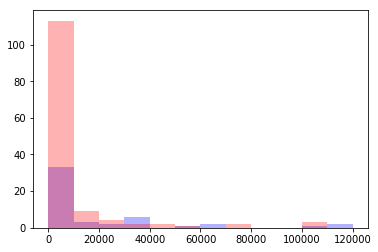

In [10]:
import matplotlib.pyplot as plt

# Plot a couple histograms to see if the +speck and -speck groups differ appreciably
plt.hist(irak1_timeseries[ascspeck_TF].iloc[:,8], bins = 12, range = (0,120000), alpha = 0.3, lw=3, color= 'b')
plt.hist(irak1_timeseries[~ascspeck_TF].iloc[:,8], bins = 12, range = (0,120000), alpha = 0.3, lw=3, color= 'r')

From the histograms, it is difficult to distinguish the +speck (blue) and -speck (red) groups on a single time point. Therefore, I will try two dimensionality-reduction methods to see if the groups separate more clearly when all available time points are considered.

Independent component analysis (ICA) is a linear dimensionality-reduction method related to PCA, but in some cases more suitable for time-series data because it considers higher-order statistics. ICA has been used in several time-series applications previous, such as https://link.springer.com/chapter/10.1007/978-3-642-34904-1_45.

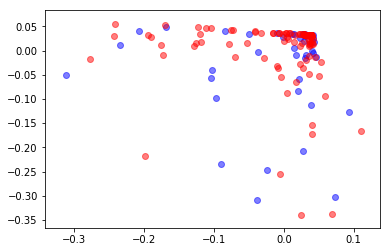

In [11]:
# Independent component analysis (ICA)
from sklearn.decomposition import FastICA

ica = FastICA(n_components = 2)
decomp = ica.fit_transform(irak1_norm)  # Reconstruct signals
mixing = ica.mixing_  # Get estimated mixing matrix

plt.scatter(decomp[ascspeck_TF][:,0], decomp[ascspeck_TF][:,1], alpha = 0.5, color= 'b') 
plt.scatter(decomp[~ascspeck_TF][:,0], decomp[~ascspeck_TF][:,1], alpha = 0.5, color= 'r') 

ICA doesn't separate the two groups very well, so I will also try t-stochastic neighbor embedding, a non-linear dimensionality-reduction method, to see if it yields better separation.

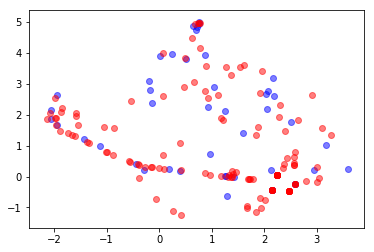

In [12]:
# t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 80) 
decomp = tsne.fit_transform(irak1_norm)  # Reconstruct signals

plt.scatter(decomp[ascspeck_TF][:,0], decomp[ascspeck_TF][:,1], alpha = 0.5, color= 'b') 
plt.scatter(decomp[~ascspeck_TF][:,0], decomp[~ascspeck_TF][:,1], alpha = 0.5, color= 'r') 

t-SNE also fails to show convincing separation between the two groups, so it seems that in general dimensionality reduction is not a good strategy for this data. I will therefore use all the dimensions (time points) of the data in an initial attempt at classification. 

I will initially try 3 classification methods: KNN, random forest, and support vector machine.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Initialize KNN classifier
knnc = KNeighborsClassifier(n_neighbors = 5)

# Initialize Random forest classifier
rfc = RandomForestClassifier(n_estimators = 10)

# Initialize support vector classifier
svc = SVC(gamma = 'scale', kernel = 'rbf')

In [14]:
# This is the accuracy you'd get just by guessing FALSE on every cell - need to beat this!
np.sum(~ascspeck_TF) / ascspeck_TF.size

0.7311827956989247

(array([ 2.,  1.,  6.,  7., 20., 33., 12., 13.,  4.,  2.]),
 array([0.55319149, 0.58297872, 0.61276596, 0.64255319, 0.67234043,
        0.70212766, 0.73191489, 0.76170213, 0.79148936, 0.8212766 ,
        0.85106383]),
 <a list of 10 Patch objects>)

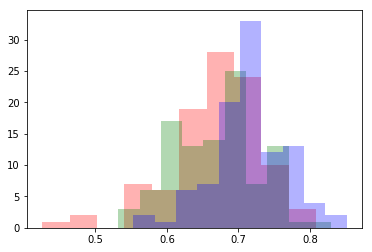

In [17]:
# Assess accuracy of each classification method with a train & test set
# The data set's pretty small, so a 75-25 train-test split will be used to give enough test data
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split

my_cv = ShuffleSplit(n_splits = 100, test_size = 0.25)

# KNN, in red
cv_scores = cross_val_score(knnc, irak1_norm, ascspeck_TF, cv = my_cv)
plt.hist(cv_scores, alpha = 0.3, color= 'r')

# Random forest, in green
cv_scores = cross_val_score(rfc, irak1_norm, ascspeck_TF, cv = my_cv)
plt.hist(cv_scores, alpha = 0.3, color= 'g')

# Support vector, in blue
cv_scores = cross_val_score(svc, irak1_norm, ascspeck_TF, cv = my_cv)
plt.hist(cv_scores, alpha = 0.3, color= 'b')

The support vector classifier appears to be the most accurate. However, none of the methods seems to consistently beat the ~73% accuracy that you would obtain just by calling "false" for all samples. To see if that's happening, check the confusion matrix. I'll use a function to plot a confusion matrix visually, taken from the scikit-learn docs (https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

Confusion matrix, without normalization
[[27  4]
 [14  2]]
Confusion matrix, without normalization
[[29  2]
 [16  0]]
Confusion matrix, without normalization
[[31  0]
 [16  0]]


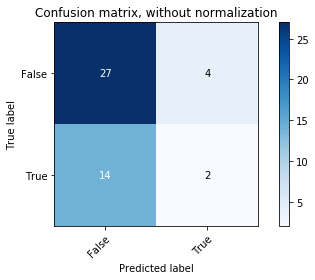

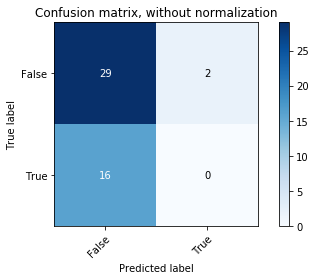

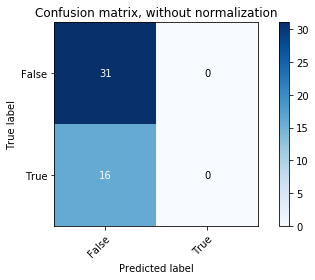

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# From https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# Plots a confusion matrix with labels and color intensity
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

X_train, X_test, y_train, y_test = train_test_split(irak1_norm, ascspeck_TF, test_size=.25)

knnc = knnc.fit(X_train, y_train)
y_pred = knnc.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes = ['False','True'])

rfc = rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes = ['False','True'])

svc = svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes = ['False','True'])

These confusion matrices indicate that all of these methods are predicting "no speck" for basically all the test samples. This is not ideal behavior even though it gives ~70% accuracy, because it does not reval anything about the underlying biology.

__Refinement 1: Imbalanced Learning__

It may be that the problem is that only about 25% of cells in the data set form ASC specks, and an imbalanced learning approach is called for. I will use random under-sampling to reduce the training set so it contains the sample number of +speck and -speck samples.

Confusion matrix, without normalization
[[15 15]
 [10  7]]
Confusion matrix, without normalization
[[20 10]
 [13  4]]
Confusion matrix, without normalization
[[29  1]
 [11  6]]


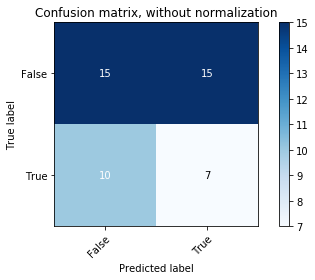

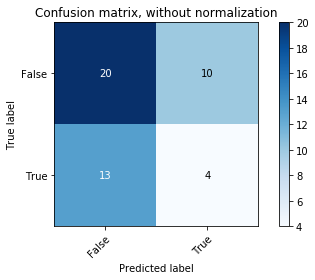

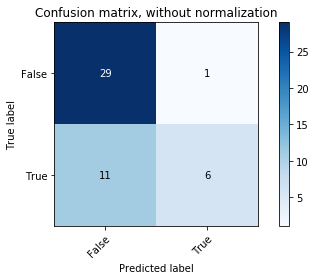

In [24]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

# Create a training set 
X_train, X_test, y_train, y_test = train_test_split(irak1_norm, ascspeck_TF, test_size=.25)

# Set up pipelines with random under-sampling to equalize +speck and -speck groups for each algorithm
us_knnc = make_pipeline(RandomUnderSampler(), KNeighborsClassifier(n_neighbors = 5))
us_rfc = make_pipeline(RandomUnderSampler(), RandomForestClassifier(n_estimators = 10))
us_svc = make_pipeline(RandomUnderSampler(), SVC(gamma = 'scale', kernel = 'rbf'))

# Check confusion matrices for each classification algorithm to see if they're still calling FALSE for all samples
# KNN
us_knnc.fit(X_train, y_train)
y_pred = us_knnc.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes = ['False','True'])

# Random forest
us_rfc.fit(X_train, y_train)
y_pred = us_rfc.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes = ['False','True'])

# Support vector
us_svc.fit(X_train, y_train)
y_pred = us_svc.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes = ['False','True'])

Encouragingly, the use of under-sampling causes more samples to be predicted as +speck for each of the classification algorithms. Thus, cross-validate to see how well each algorithm now performs.

(array([ 2.,  0.,  0.,  0.,  5., 11., 19., 41., 15.,  7.]),
 array([0.29787234, 0.34893617, 0.4       , 0.45106383, 0.50212766,
        0.55319149, 0.60425532, 0.65531915, 0.70638298, 0.75744681,
        0.80851064]),
 <a list of 10 Patch objects>)

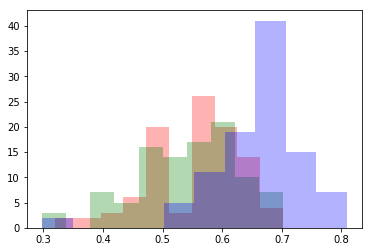

In [28]:
my_cv = ShuffleSplit(n_splits = 100, test_size = 0.25)
plt.figure()

# KNN, in red
cv_scores = cross_val_score(us_knnc, irak1_norm, ascspeck_TF, cv = my_cv)
plt.hist(cv_scores, alpha = 0.3, color= 'r')

# Random forest, in green
cv_scores = cross_val_score(us_rfc, irak1_norm, ascspeck_TF, cv = my_cv)
plt.hist(cv_scores, alpha = 0.3, color= 'g')

# Support vector, in blue
cv_scores = cross_val_score(us_svc, irak1_norm, ascspeck_TF, cv = my_cv)
plt.hist(cv_scores, alpha = 0.3, color= 'b')

The support vector method (blue) now clearly outperforms the other two methods. However, the accuracy remains near 70%, no real improvement over the prior situation.

__Refinement 2: Feature Extraction__

Another way to analyze time-series data is by extracting independent features from each time series - the mean, variance, quantiles, rates of change, etc. This functionality has been implemented in Python in the _tsfresh_ package, which will also automatically strip the extracted features of non-informative ones (e.g. features where all values are zero).

In [29]:
# To use tsfresh, the data must be reshaped so that each row represents a single time point for a single cell.
irak1_reshape = irak1_timeseries.stack()
irak1_reshape.index.rename([ 'cell', 'time' ], inplace = True )
irak1_reshape = irak1_reshape.reset_index()
irak1_reshape.head()

,cell,time,0
0,"('C5', 1, 17)",t8,0.0
1,"('C5', 1, 17)",t9,0.0
2,"('C5', 1, 17)",t10,1600.0
3,"('C5', 1, 17)",t11,1547.0
4,"('C5', 1, 17)",t12,3313.0


In [30]:
# Use tsfresh to extract features
import tsfresh as tsf
irak1_features = tsf.extract_features(irak1_reshape, column_id="cell", column_sort="time")

# This function fills in NaN values in the extracted features
tsf.utilities.dataframe_functions.impute(irak1_features)

# Select a subset of the features that are imformative about the ASC speck status
irak1_features_filt = tsf.select_features(irak1_features, ascspeck_TF, fdr_level=0.5)

Feature Extraction: 100%|██████████| 10/10 [00:13<00:00,  1.22s/it]
 '0__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 '0__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 '0__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 '0__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 '0__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 '0__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 '0__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 '0__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 '0__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 '0__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 '0__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 '0__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 '0__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 '0__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"slope"'
 '0__agg_line

In [31]:
# See what the extracted features look like
irak1_features_filt.head()

variable,0__c3__lag_3,0__quantile__q_0.4,"0__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.4",0__quantile__q_0.6,"0__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.0","0__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.2","0__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.0","0__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.0","0__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","0__change_quantiles__f_agg_""mean""__isabs_True__qh_0.2__ql_0.0",...,0__median,0__energy_ratio_by_chunks__num_segments_10__segment_focus_2,0__percentage_of_reoccurring_values_to_all_values,0__percentage_of_reoccurring_datapoints_to_all_datapoints,0__ratio_value_number_to_time_series_length,0__range_count__max_1__min_-1,0__value_count__value_0,"0__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""intercept""",0__quantile__q_0.2,"0__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_20"
id,,,,,,,,,,,,,,,,,,,,,
"('C5', 1, 109)",2.328233e+12,7339.0,3766.0,11105.0,1.065679e+07,2184.333333,2984.600000,2107.0,1.251415e+06,3534.0,...,8370.0,0.120156,0.000000,0.000000,1.000000,1.0,1.0,1213.333333,4552.0,27708.723086
"('C5', 1, 127)",0.000000e+00,0.0,10.5,4331.0,3.307500e+02,10.500000,10.500000,0.0,3.307500e+02,0.0,...,4289.0,0.020319,0.454545,0.142857,0.636364,5.0,5.0,0.000000,0.0,7329.553775
"('C5', 1, 147)",8.201822e+11,8363.0,0.0,8944.0,2.240030e+07,2016.000000,4126.600000,4566.0,1.246090e+05,3527.0,...,8479.0,0.133944,0.000000,0.000000,1.000000,1.0,1.0,5672.000000,6575.0,15040.871178
"('C5', 1, 165)",1.371826e+11,3186.0,390.0,7384.0,1.113882e+07,2114.000000,2114.000000,1062.0,7.374750e+06,0.0,...,6994.0,0.180095,0.272727,0.111111,0.818182,3.0,3.0,1195.666667,0.0,12105.247565
"('C5', 1, 17)",7.753939e+09,1600.0,0.0,1758.0,6.400487e+05,574.333333,574.333333,26.5,6.007109e+05,0.0,...,1670.0,0.058609,0.272727,0.111111,0.818182,3.0,3.0,0.000000,0.0,2530.853459


In [32]:
# Now we can perform proper min-max normalization
from sklearn.preprocessing import minmax_scale
irak1_features_filt_norm = minmax_scale(irak1_features_filt)

Once again, run dimensionality reduction to see if the +speck and -speck groups now separate.

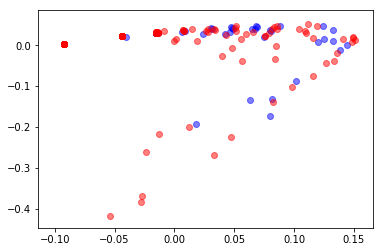

In [33]:
# Independent component analysis on extracted features
ica = FastICA(n_components = 2)
decomp = ica.fit_transform(irak1_features_filt_norm)  # Reconstruct signals
mixing = ica.mixing_  # Get estimated mixing matrix

plt.scatter(decomp[ascspeck_TF][:,0], decomp[ascspeck_TF][:,1], alpha = 0.5, color= 'b') 
plt.scatter(decomp[~ascspeck_TF][:,0], decomp[~ascspeck_TF][:,1], alpha = 0.5, color= 'r') 

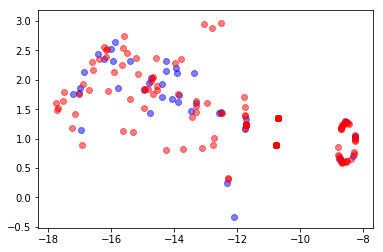

In [34]:
#T-SNE on extracted features
tsne = TSNE(n_components = 2, perplexity = 80)
decomp = tsne.fit_transform(irak1_features_filt_norm)

plt.scatter(decomp[ascspeck_TF][:,0], decomp[ascspeck_TF][:,1], alpha = 0.5, color= 'b') 
plt.scatter(decomp[~ascspeck_TF][:,0], decomp[~ascspeck_TF][:,1], alpha = 0.5, color= 'r')

Still, the dimensionality reduction methods don't show a clear separation between the +speck and -speck groups.

In light of that, proceed with clustering algorithms without further dimensionality reduction. I will use the same methods as used above for the original time-series data, including random under-sampling.

Confusion matrix, without normalization
[[25 13]
 [ 4  5]]
Confusion matrix, without normalization
[[22 16]
 [ 6  3]]
Confusion matrix, without normalization
[[22 16]
 [ 2  7]]


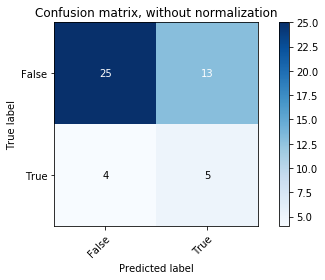

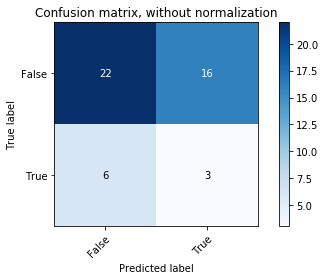

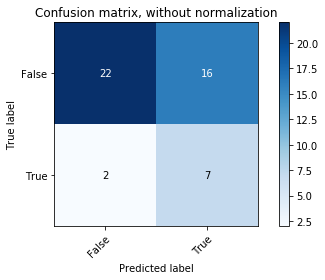

In [36]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(irak1_features_filt_norm, ascspeck_TF, test_size=.25)

# Set up pipelines with random under-sampling to equalize +speck and -speck groups for each algorithm
us_knnc = make_pipeline(RandomUnderSampler(), KNeighborsClassifier(n_neighbors = 5))
us_rfc = make_pipeline(RandomUnderSampler(), RandomForestClassifier(n_estimators = 10))
us_svc = make_pipeline(RandomUnderSampler(), SVC(gamma = 'scale', kernel = 'rbf'))

# Check confusion matrices for each classification algorithm to see if they're still calling FALSE for all samples
# KNN
us_knnc.fit(X_train, y_train)
y_pred = us_knnc.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes = ['False','True'])

# Random forest
us_rfc.fit(X_train, y_train)
y_pred = us_rfc.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes = ['False','True'])

# Support vector
us_svc.fit(X_train, y_train)
y_pred = us_svc.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes = ['False','True'])

The confusion matrices suggest that feature extraction, relative to using the raw time series data, causes the classification algorithms to predict a larger proportion of test samples as +speck. Finally, cross-validate to get a sense of the overall performance of each algorithm:

(array([ 1.,  2.,  2.,  1.,  6.,  3., 23., 33., 25.,  4.]),
 array([0.29787234, 0.34042553, 0.38297872, 0.42553191, 0.46808511,
        0.5106383 , 0.55319149, 0.59574468, 0.63829787, 0.68085106,
        0.72340426]),
 <a list of 10 Patch objects>)

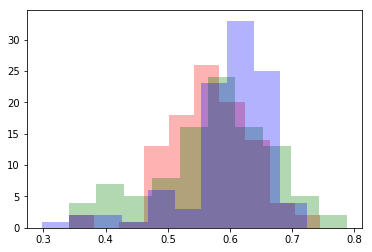

In [39]:
my_cv = ShuffleSplit(n_splits = 100, test_size = 0.25)
plt.figure()

# KNN, in red
cv_scores = cross_val_score(us_knnc, irak1_features_filt_norm, ascspeck_TF, cv = my_cv)
plt.hist(cv_scores, alpha = 0.3, color= 'r')

# Random forest, in green
cv_scores = cross_val_score(us_rfc, irak1_features_filt_norm, ascspeck_TF, cv = my_cv)
plt.hist(cv_scores, alpha = 0.3, color= 'g')

# Support vector, in blue
cv_scores = cross_val_score(us_svc, irak1_features_filt_norm, ascspeck_TF, cv = my_cv)
plt.hist(cv_scores, alpha = 0.3, color= 'b')

The performance of the three algorithms is much closer using the extracted features as opposed to the raw time-series data, where both KNN and random forest performed poorly. Here, their performance is comparable to the performance of the support vector model. However, none of the models exceeds 70% average performance. Further collection of higher-quality data and refinement of preprocessing is likely needed before a machine learning algorithm can more reliably predict ASC speck formation from IRAK1 cluster time series data.  